In [1]:
import os, logging
import re
import math
import json
from pathlib import Path
from tqdm import tqdm
import random
from dotenv import load_dotenv
from huggingface_hub import login
import numpy as np
import pickle
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import chromadb
from sklearn.manifold import TSNE
import plotly.graph_objects as go
from lib.items import Item
from lib.utils import description, get_price, Tester
from openai import OpenAI
import modal
from lib.agents.frontier_agent import FrontierAgent
from lib.agents.specialist_agent import SpecialistAgent

# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [2]:
%cd ../..
project_folder = Path("AI/deals_agents")
preprocessed_data = project_folder/"output"/"preprocessed_data"
lib = project_folder/"lib"
DB = project_folder/"output"/"products_vectorstore"

/home/hien/Work


In [3]:
# loading the pkl files

with open(preprocessed_data/'train_lite.pkl', 'rb') as file:
    train = pickle.load(file)

with open(preprocessed_data/'test_lite.pkl', 'rb') as file:
    test = pickle.load(file)

# Frontier Agent - RAG Pipeline

## Chroma Datastore

### Create A Collection

In [4]:
client = chromadb.PersistentClient(path=DB)

In [5]:
# Check if the collection exists and delete it if it does
collection_name = "products"

existing_collection_names = client.list_collections()

if collection_name in existing_collection_names:
    client.delete_collection(collection_name)
    print(f"Deleted existing collection: {collection_name}")

collection = client.create_collection(collection_name, get_or_create=True)

In [6]:
# maps sentences & paragraphs to a 384 dimensional dense vector space

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

### Populate RAG datastore

In [7]:
NUMBER_OF_DOCUMENTS = len(train)

for i in tqdm(range(0, NUMBER_OF_DOCUMENTS, 1000)):
    documents = [description(item) for item in train[i: i+1000]]
    vectors = model.encode(documents).astype(float).tolist()
    metadatas = [{"category": item.category, "price": item.price} for item in train[i: i+1000]]
    ids = [f"doc_{j}" for j in range(i, i+len(documents))]
    collection.add(
        ids=ids,
        documents=documents,
        embeddings=vectors,
        metadatas=metadatas
    )

100%|██████████| 25/25 [00:14<00:00,  1.69it/s]


### Visualization

In [8]:
MAXIMUM_DATAPOINTS = 10_000
CATEGORIES = ["Appliances", "Electronics", "Toys_and_Games", "Musical_Instruments"]
COLORS = ['red', 'blue', 'brown', 'orange']

# Prework
result = collection.get(include=['embeddings', 'documents', 'metadatas'], limit=MAXIMUM_DATAPOINTS)
vectors = np.array(result['embeddings'])
documents = result['documents']
categories = [metadata['category'] for metadata in result['metadatas']]
colors = [COLORS[CATEGORIES.index(c)] for c in categories]

In [9]:
# Let's try a 2D chart

tsne = TSNE(n_components=2, random_state=42, n_jobs=-1)
reduced_vectors = tsne.fit_transform(vectors)

In [10]:
# Create the 2D scatter plot
fig = go.Figure(data=[go.Scatter(
    x=reduced_vectors[:, 0],
    y=reduced_vectors[:, 1],
    mode='markers',
    marker=dict(size=3, color=colors, opacity=0.7),
)])

fig.update_layout(
    title='2D Chroma Vectorstore Visualization',
    scene=dict(xaxis_title='x', yaxis_title='y'),
    width=1200,
    height=800,
    margin=dict(r=20, b=10, l=10, t=40)
)

fig.show()

## Building and Testing RAG Pipeline

### Building

In [11]:
def make_context(similars, prices):
    message = "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\n"
    for similar, price in zip(similars, prices):
        message += f"Potentially related product:\n{similar}\nPrice is ${price:.2f}\n\n"
    return message

def rag_messages_for(item, similars, prices):
    system_message = "You estimate prices of items. Reply only with the price, no explanation"
    user_prompt = make_context(similars, prices)
    user_prompt += "And now the question for you:\n\n"
    user_prompt += item.test_prompt().replace(" to the nearest dollar","").replace("\n\nPrice is $","")
    return [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": "Price is $"}
    ]

def vector(item):
    return model.encode([description(item)])

def find_similars(item):
    results = collection.query(query_embeddings=vector(item).astype(float).tolist(), n_results=5)
    documents = results['documents'][0][:]
    prices = [m['price'] for m in results['metadatas'][0][:]]
    return documents, prices

In [12]:
print(test[1].prompt)

How much does this cost to the nearest dollar?

Black Tilting Wall Mount Bracket for Vizio VX42L LCD 42 inch HDTV TV
This high quality tilting wall mount bracket supports most* 36 to 63 flat panel screen LCD/plasma TVs and monitors. The mount includes simple to align brackets and a unique wall plate that can be mounted to two studs or concrete and comes with mounting hardware and installation instructions for a quick and easy installation. It's toughened steel construction supports up to 165lbs and has a variable 0° to -15° downward tilt. *Mounting holes on television should be 28 or less apart horizontally and 18.5 or less apart vertically Color Black scratch resistant finish Fits most 36 to 63 LCD and Plasma Tv's (Supports VESA Standards up to 750 x 

Price is $100.00


In [13]:
documents, prices = find_similars(test[1])

In [14]:
print(make_context(documents, prices))

To provide some context, here are some other items that might be similar to the item you need to estimate.

Potentially related product:
VideoSecu Black Tilt Wall Mount Bracket for Vizio 37 to 75 inch HDTV Plasma LCD LED TV MP502B
The tilt wall mount offers 15 degrees of forward tilt while maintaining a slim profile only 2.2 away from the wall in the flat position. Weight capacity 165lbs supports hole pattern up to 28 wide by 18 tall, including VESA mount fits most 37 -75 plasma or LCD TV. It could mount to any stud separation up to 28. Safety bolts system-Lift and lock mounting Just attach the pre-assembled arms on the back of the display to the wall plate, then tighten the security screws lock the display in position as needed. This mount is VideoSecu brand. Please report to Amazon.com if you receive a mount
Price is $29.99

Potentially related product:
VideoSecu Black Tilting Wall Mount Bracket for Samsung 37-75 inch 4K Ultra HD Smart LED TV MP502B
This is an Angle Adjustable Black 

In [15]:
print(rag_messages_for(test[1], documents, prices))

[{'role': 'system', 'content': 'You estimate prices of items. Reply only with the price, no explanation'}, {'role': 'user', 'content': "To provide some context, here are some other items that might be similar to the item you need to estimate.\n\nPotentially related product:\nVideoSecu Black Tilt Wall Mount Bracket for Vizio 37 to 75 inch HDTV Plasma LCD LED TV MP502B\nThe tilt wall mount offers 15 degrees of forward tilt while maintaining a slim profile only 2.2 away from the wall in the flat position. Weight capacity 165lbs supports hole pattern up to 28 wide by 18 tall, including VESA mount fits most 37 -75 plasma or LCD TV. It could mount to any stud separation up to 28. Safety bolts system-Lift and lock mounting Just attach the pre-assembled arms on the back of the display to the wall plate, then tighten the security screws lock the display in position as needed. This mount is VideoSecu brand. Please report to Amazon.com if you receive a mount\nPrice is $29.99\n\nPotentially relate

### Testing

In [16]:
client = OpenAI()

def gpt_4o_mini_rag(item):
    documents, prices = find_similars(item)
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=rag_messages_for(item, documents, prices),
        seed=42,
        max_tokens=5
    )
    reply = response.choices[0].message.content
    return get_price(reply)


1: Guess: $21.99 Truth: $21.99 Error: $0.00 SLE: 0.00 Item: The Petting Zoo Bald Eagle Stuffed Animal, Gifts for Kids, Wild Onez Zoo Animals, Bald Eagle Plush Toy 12 inches
2: Guess: $29.99 Truth: $99.99 Error: $70.00 SLE: 1.40 Item: Black Tilting Wall Mount Bracket for Vizio VX42L LCD 42 inch HDTV TV
3: Guess: $129.99 Truth: $199.00 Error: $69.01 SLE: 0.18 Item: Xantech Ensemble Universal IR Kit EN85K
4: Guess: $14.99 Truth: $15.99 Error: $1.00 SLE: 0.00 Item: Teenager Birthday Party Decoration 13th Birthday Party Decorations for Girls, Omg Ur A Teenager Birthday Banner Rose Gold 13 Birthday Balloons Confetti Balloons for 13th Birthday Girls Her Daughter
5: Guess: $209.99 Truth: $229.99 Error: $20.00 SLE: 0.01 Item: Kodak PIXPRO Astro Zoom AZ421 16MP Digital Camera (White) Bundle with 32GB SD Card, Camera Case and Accessory Bundle (4 Items)
6: Guess: $149.99 Truth: $24.44 Error: $125.55 SLE: 3.17 Item: Blessing Alto Saxophone Case (MPC7CTR)
7: Guess: $15.99 Truth: $9.99 Error: $6.00 S

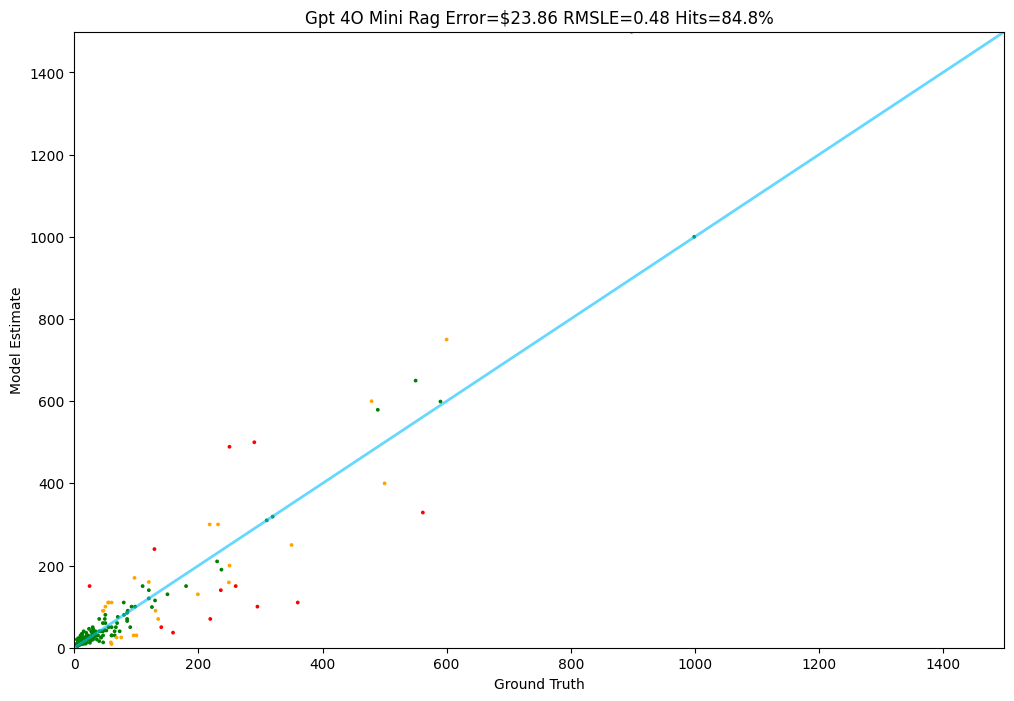

In [17]:
Tester.test(gpt_4o_mini_rag, test)

## Creating a Frontier Agent using RAG

In [ ]:
# Let's print the logs so we can see what's going on
root = logging.getLogger()
root.setLevel(logging.INFO)
frontier_agent = FrontierAgent(collection)
frontier_agent.price("Quadcast HyperX condenser mic for high quality podcasting")

INFO:root:[Frontier Agent] Initializing Frontier Agent
INFO:root:[Frontier Agent] Frontier Agent is setting up with OpenAI
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda:0
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
INFO:root:[Frontier Agent] Frontier Agent is ready
INFO:root:[Frontier Agent] Frontier Agent is performing a RAG search of the Chroma datastore to find 5 similar products


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:root:[Frontier Agent] Frontier Agent has found similar products
INFO:root:[Frontier Agent] Frontier Agent is about to call gpt-4o-mini with context including 5 similar products
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:[Frontier Agent] Frontier Agent completed - predicting $139.99


139.99

# Fine-tuned Agent

In [2]:
agent = SpecialistAgent()

In [6]:
# Use the Llama-based model
agent.price("Quadcast HyperX condenser mic for high quality podcasting", model="llama")

60.0

In [5]:
# Use the GPT-based model
agent.price("Quadcast HyperX condenser mic for high quality podcasting", model="gpt")

139.0

# Ensemble Agent

# Scanning Agent

In [23]:
from lib.agents.scanner_agent import ScannerAgent
scanner_agent = ScannerAgent()
scanning_result = scanner_agent.scan()
scanning_result

INFO:root:[Scanner Agent] Scanner Agent is initializing
INFO:root:[Scanner Agent] Scanner Agent is ready
INFO:root:[Scanner Agent] Scanner Agent is about to fetch deals from RSS feed
INFO:root:[Scanner Agent] Scanner Agent received 50 deals not already scraped
INFO:root:[Scanner Agent] Scanner Agent is calling OpenAI using Structured Output
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:[Scanner Agent] Scanner Agent received 5 selected deals with price>0 from OpenAI


DealSelection(deals=[Deal(product_description="The Samsung QN75LS03DAFXZA The Frame is a 75-inch 4K HDR QLED TV that blends seamlessly into your decor with its customizable bezels. It features a stunning 120Hz refresh rate along with HDR 10+ technology, ensuring vibrant and lifelike images. The TV supports multiple voice assistants like Amazon Alexa, Bixby, and Google Assistant for hands-free control. With four HDMI 2.1 ports, it's designed for modern gaming and streaming setups, making it a versatile choice for entertainment enthusiasts.", price=1500.0, url='https://www.dealnews.com/products/Samsung/Samsung-QN75-LS03-DAFXZA-The-Frame-LS03-D-75-4-K-HDR-QLED-TV/478668.html?iref=rss-c142'), Deal(product_description='The Jackery 3000 Pro Portable Power Station has a massive 3,024Wh capacity and outputs 3,000W of power, making it ideal for camping, tailgating, or emergency situations. It includes two 200W solar panels for recharging, allowing for sustainable power wherever you are. The uni